L'objectif est de **proposer une baseline à partir d'un CNN** : le modèle choisi est **LeNet**.

Dans un premier temps, les images sont groupées en 11 classes :

- **BA** : BAsophiles
- **BNE** : NEutrophiles de Bande
- **EO** : EOsinophiles
- **ERB** : ERythroBlastes
- **LY** : LYmphocytes
- **MMY** : MétaMYélocytes
- **MO** : MOnocytes
- **MY** : MYélocytes
- **PLT** : PLaqueTtes
- **PMY** : Promyélocytes
- **SNE** : NEutrophiles Segmentés

# Modules, connexion au Drive, vérification du GPU

In [ ]:
## Gives access to the Drive
from google.colab import drive
drive.mount('/content/drive')

## Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib. as cm
import cv2

import sys, os
from pathlib import Path
import glob
import itertools

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append('/content/drive/MyDrive/Leukopy')
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

## GPU status verification
tf.test.gpu_device_name()

## GPU type verification
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
Tue Oct 26 09:39:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |    345MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

# Import des données

Les données de Barcelone ont été placées au préalable dans trois répertoires : training_set, testing_set et validation_set. Cela permet de s'assurer que nous utilisons les mêmes jeux avec tous nos modèles. 

Les données sont stockées sur GoogleDrive, il faut d'abord les importer sur la machine virtuelle de GoogleColab avant de faire quoi que ce soit.

In [ ]:
## Need to copy all the files on the local computer
!cp -r "/content/drive/MyDrive/Leukopy/data/main_dataset.zip" .
!unzip main_dataset.zip

## Create the original dataframes
path = Path('/content/main_dataset/')

df_train = leuko.generate_images_df(path/'training_set')
df_test = leuko.generate_images_df(path/'testing_set')
df_valid = leuko.generate_images_df(path/'validation_set')

# Preprocessing des données

On élimine le label "BL" du dataset : trop peu d'images, trop différentes du reste de Barcelone.

On définit une fonction permettant de travailler à 11 ou 8 classes, ce qui sera utile plus loin.

In [ ]:
def choose_classes(df_train, df_test, df_valid, n_classes = 11):

  """ Pour travailler avec 11 ou 8 classes. Les BL (blastes) sont une classe de cellules minoritaires provenant d'un dataset différent de celui fournissant les
  images des N-1 autres classes. En raison d'un biais évident, nous ne travaillons pas avec ces images.
  """

  # Option à 11 classes, sans les BL
  if n_classes == 11:
    df_train = df_train[df_train["label"] != "BL"]
    df_test = df_test[df_test["label"] != "BL"]
    df_valid = df_valid[df_valid["label"] != "BL"]

  # Option à 8 classes (IG, SNE et BNE dans la même classe "NEU"), sans les BL :
  if n_classes == 8:

    # Elimine les BL :
    df_train = df_train[df_train["label"] != "BL"]
    df_test = df_test[df_test["label"] != "BL"]
    df_valid = df_valid[df_valid["label"] != "BL"]

    # Renomme SNE/BNE en NEU :
    df_train["label_3"] = df_train["label_3"].replace(to_replace = ["SNE","BNE"], value = ["NEU","NEU"])
    df_valid["label_3"] = df_valid["label_3"].replace(to_replace = ["SNE","BNE"], value = ["NEU","NEU"])
    df_test["label_3"] = df_test["label_3"].replace(to_replace = ["SNE","BNE"], value = ["NEU","NEU"])

    # Sélectionne les label_3 comme labels :
    df_train["label"] = df_train["label_3"]
    df_test["label"] = df_test["label_3"]
    df_valid["label"] = df_valid["label_3"]

  return n_classes, df_train, df_test, df_valid

In [ ]:
n_classes, df_train, df_test, df_valid = choose_classes(df_train, df_test, df_valid, n_classes = 11)
classes = list(df_train["label"].sort_values().unique())

On découpe les données en une série de batchs de 32 images. Les images sont redimensionnées (256 * 256 pixels). Pour l'instant, on travaille sans augmentation de données.

In [ ]:
batch_size = 32
img_height  = 256
img_width = 256

train_generator = ImageDataGenerator()
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()


# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12677 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.
Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


# Modèle

In [ ]:
model = Sequential(
    [layers.experimental.preprocessing.Rescaling(1./255, 
                                                 input_shape = (img_height, img_width, 3)),
     layers.Conv2D(filters = 30,
                   kernel_size = (5,5),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(filters = 16,
                   kernel_size = (3,3),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Dropout(rate = 0.2),
     layers.Flatten(),
     layers.Dense(units = 128, activation = 'relu'),
     layers.Dense(units = n_classes, activation  = 'softmax')
     ])

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [ ]:
# Structure du modèle
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 252, 252, 30)      2280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 30)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 16)      4336      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 61504)            

# Modèle à 11 classes

## Entraînement

On adapte le learning-rate au fur et à mesure de l'entraînement grâce à ReduceLROnPlateau. L'entraînement cesse lorsque la valeur de la fonction de coût calculée pour le jeu de validation ne diminue plus.

In [ ]:
## Training

TON = TerminateOnNaN()
control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]

epochs = 100
training_history = model.fit(x = training_set, 
                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set)

Epoch 1/100
397/397 [==============================] - 41s 103ms/step - loss: 1.3512 - accuracy: 0.5452 - val_loss: 0.8758 - val_accuracy: 0.6821
Epoch 2/100
397/397 [==============================] - 41s 102ms/step - loss: 0.6289 - accuracy: 0.7678 - val_loss: 0.6275 - val_accuracy: 0.7671
Epoch 3/100
397/397 [==============================] - 41s 102ms/step - loss: 0.4254 - accuracy: 0.8407 - val_loss: 0.6164 - val_accuracy: 0.7769
Epoch 4/100
397/397 [==============================] - 41s 103ms/step - loss: 0.3059 - accuracy: 0.8871 - val_loss: 0.5631 - val_accuracy: 0.7988
Epoch 5/100
397/397 [==============================] - 41s 102ms/step - loss: 0.2085 - accuracy: 0.9236 - val_loss: 0.6330 - val_accuracy: 0.7850
Epoch 6/100
397/397 [==============================] - 41s 103ms/step - loss: 0.1523 - accuracy: 0.9460 - val_loss: 0.7583 - val_accuracy: 0.7734

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
397/397 [=====================

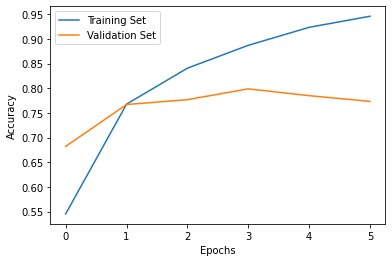

In [ ]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(training_accuracy, label = 'Training Set')
plt.plot(validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

On remarque un **fort surapprentissage** : l'accuracy globale calculée pour le jeu d'entraînement dépasse les 95% mais celle mesurée pour le jeu de validation plafonne au mieux à 80%. 

## Évaluation

### Fonctions

In [ ]:
def print_classification_report(testing_set, labels, title):
  """
  Rapport de classification + Matrice de confusion
  """
  # Prédiction : utilise le jeu de test (testing_set)
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Calcul et affichage de la matrice de confusion
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred, normalize = 'true')
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion - "+title)
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, np.around(cnf_matrix[i, j], decimals = 3),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Rapport de classification 
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report - "+title)
  return y_pred, display(df_report)

In [ ]:
def full_prediction(model, img_path, label, size = (img_height, img_width)):

  ## Preprocessing de l'image
  img = get_img_array(img_path, size = size)

  ## Prediction
  probas = model.predict(img)[0]
  sorted_indexes = np.flip(np.argsort(probas))
  sorted_classes = [classes[i] for i in sorted_indexes]
  sorted_probas = [probas[i] for i in sorted_indexes]
  
  ## Plot (3 classes les plus probables)
  fig = plt.figure(figsize = (7,7))

  ax1 = fig.add_subplot(1,1,1)
  ax1.imshow(plt.imread(img_path))
  ax1.text(x = 10, y = 25, s = 'P(%s) = %0.3f'%(sorted_classes[0], sorted_probas[0]), fontsize = 'xx-large')
  ax1.text(x = 10, y = 55, s = 'P(%s) = %0.3f'%(sorted_classes[1], sorted_probas[1]), fontsize = 'xx-large')
  ax1.text(x = 10, y = 85, s = 'P(%s) = %0.3f'%(sorted_classes[2], sorted_probas[2]), fontsize = 'xx-large')
  ax1.set_title('True label : '+label+'\nPath : '+img_path)
  plt.grid(None)
  plt.axis('off')

  return probas, sorted_probas, sorted_classes

In [ ]:
def get_img_array(img_path, size = (img_height, img_width)):
  """
  Importe une image et applique le preprocessing nécessaire à l'utilisation de Xception : batch + preprocess_input
  """
  img_array = tf.keras.preprocessing.image.load_img(img_path, target_size = size)
  img_array = tf.keras.preprocessing.image.img_to_array(img_array)
  img_array = np.expand_dims(img_array, axis = 0)

  return img_array


def make_heatmap(img_array, model, last_conv_layer, class_index):
  """
  Calcule la CAM (Class Activation Map) correspondant au label d'indice "class_index" pour l'image "img_array"
  model : un modèle déjà entraîné, dont on désactive la fonction d'activation en sortie (fait dans grandcam())
  last_conv_layer : dernière couche de convolution du modèle. Trouvée automatiquement par la fonction gradcam()
  class_index : renseigné dans l'appel de gradcam() ou trouvé automatiquement par gradcam()
  """
  grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    class_channel = preds[:, class_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

  heatmap_tmp = last_conv_layer_output[0].numpy()

  # Multiplie chaque carte d'activation par le gradient, puis moyenne
  for i in range(last_conv_layer_output.shape[3]):
    heatmap_tmp[:,:,i] *= pooled_grads[i]
  heatmap = np.mean(heatmap_tmp, axis=-1)

  return heatmap


def gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.5, plot = True):

  # Désactive softmax sur la dernière couche :
  model.layers[-1].activation = None

  # Détecte la dernière couche de convolution du modèle :
  for layer in reversed(model.layers):
    if 'conv' in layer.name:
      last_conv_layer = model.get_layer(layer.name)
      break

  # Chargement + preprocessing de l'image (conversion, batch, vgg19 special preprocessing):
  img_array = get_img_array(img_path, size = (img_height, img_width))

  # Choix de la classe à représenter (si class_index non renseigné) :
  if class_index == None :
    # Désactiver Sotfmax sur la couche de sortie :
    #model.layers[-1].activation = None                        # Modif
    # Trouve la classe la plus probable :
    predict = model.predict(img_array)
    class_index = np.argmax(predict[0])

  # Calcul de la CAM : resize pour superposition avec l'image finale
  heatmap = make_heatmap(img_array, model, last_conv_layer, class_index)
  big_heatmap = heatmap

  # Réactive softmax :
  model.layers[-1].activation = tf.keras.activations.softmax

  ## Traitement de la Heatmap
  # Applique ReLu (élimine les valeurs négatives de la heatmap)
  big_heatmap = np.maximum(0, big_heatmap)
  # Normalisation
  big_heatmap = big_heatmap/big_heatmap.max()

  ## Superposition de l'image et de la heatmap 
  # 1/ Import de l'image d'origine
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img)

  # 2/ Rescale heatmap: 0-255
  big_heatmap = np.uint8(255*big_heatmap)
  # 3/ Jet colormap
  jet = cm.get_cmap("jet")
  # 4/ Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[big_heatmap]
  # 5/ Create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
  # 6/ Superimpose the heatmap on original image
  superimposed_img = jet_heatmap*alpha + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  if plot == True:
    # 7/ Affichage des résultats
    fig = plt.figure(figsize = (8,8))
    fig.add_subplot(1,2,1)
    plt.imshow(big_heatmap)

    fig.add_subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Chosen class : "+str(list(label_map.keys())[class_index]))

  return big_heatmap, superimposed_img

### Performances - métriques :

Évaluons le modèle sur le **jeu de test**:

In [ ]:
model.evaluate(testing_set)

80/80 [==============================] - 7s 88ms/step - loss: 0.5165 - accuracy: 0.8046


[0.5164877772331238, 0.8046383857727051]

Sans grande surprise, l'accuracy globale est comparable à celle mesurée lors de l'entraînement avec le jeu de validation.

**Regardons plus en détail** en calculant les métriques appropriées (F-Score, Rappel et Précision) **pour chaque classe** :

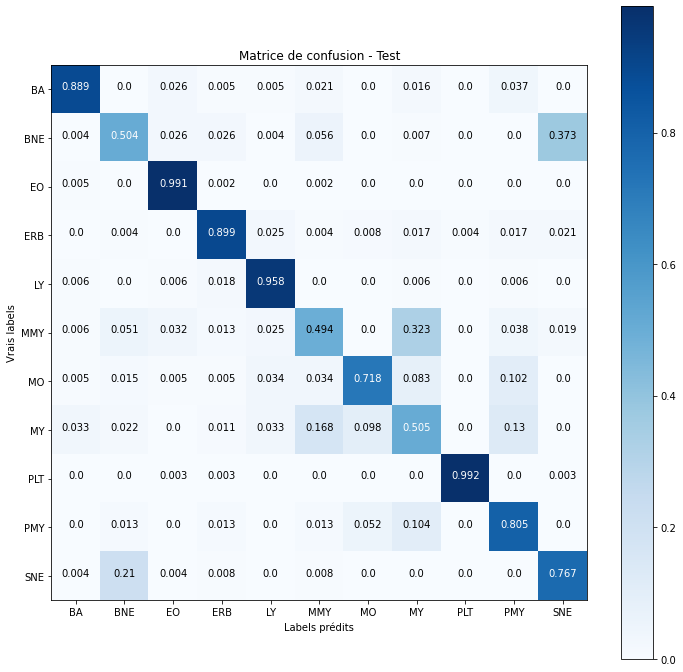

Classification Report - Test


precision    recall  f1-score support
BA   0.928177  0.888889  0.908108     189
BNE  0.652174  0.503731  0.568421     268
EO   0.953229  0.990741  0.971623     432
ERB  0.910256  0.898734  0.904459     237
LY   0.865591  0.958333  0.909605     168
MMY  0.557143  0.493671   0.52349     158
MO   0.860465  0.718447  0.783069     206
MY   0.519553  0.505435  0.512397     184
PLT   0.99723  0.991736  0.994475     363
PMY     0.496  0.805195  0.613861      77
SNE  0.648387  0.767176  0.702797     262

In [ ]:
y_pred, df_report = print_classification_report(testing_set, label_map, title = "Test")

**Certaines classes sortent du lot :** de bonnes performances sont relevées avec ce modèle simple :
- éosinophiles
- plaquettes
- basophiles, érythroblastes et lymphocytes dans une moindre mesure.

En revanche, **le modèle peine à classer correctement :**
- PMY, MY, MMY, BNE et, dans une moindre mesure, SNE

Comme il est expliqué dans le rapport, ces cellules appartiennent en réalité à la même famille : les granulocytes neutrophiles. Un promyélocyte évolue en myélocyte, puis en métamyélocyte, puis en BNE et enfin en SNE (la forme mature).

Il est donc possible que **certaines images correspondent à des cellules présentant des caractéristiques de deux stades consécutifs de l'évolution d'un granulocyte neutrophile**, rendant leur classification plus complexe.

La matrice de confusion soutient cette hypothèse, car on remarque que les principales erreurs commises en modélisant ces sous-classes consistent à confondre une image avec le stade immédiatement antérieur ou ultérieur (par exemple un MY avec un PMY ou un MMY ; ou encore un SNE avec un BNE).

### Grad-CAM :

Nous allons utiliser Grad-CAM pour déterminer ce que le modèle parvient à "retenir" des images du jeu d'entraînement.

Dans un premier temps, on stocke les résultats de l'évaluation dans un dataframe : df_results. La variable "well_classified" permet de savoir si l'image a été bien classée ou non.

In [ ]:
df_results = pd.DataFrame(data = {"label":testing_set.classes,
                                  "label_pred":y_pred, 
                                  "img_path":df_test["img_path"]})

df_results["well_classified"] = np.where(df_results["label"] == df_results["label_pred"], True, False)

Utilisons Grad-CAM sur les images bien classées : on choisit au hasard une image bien classée de chaque classe.

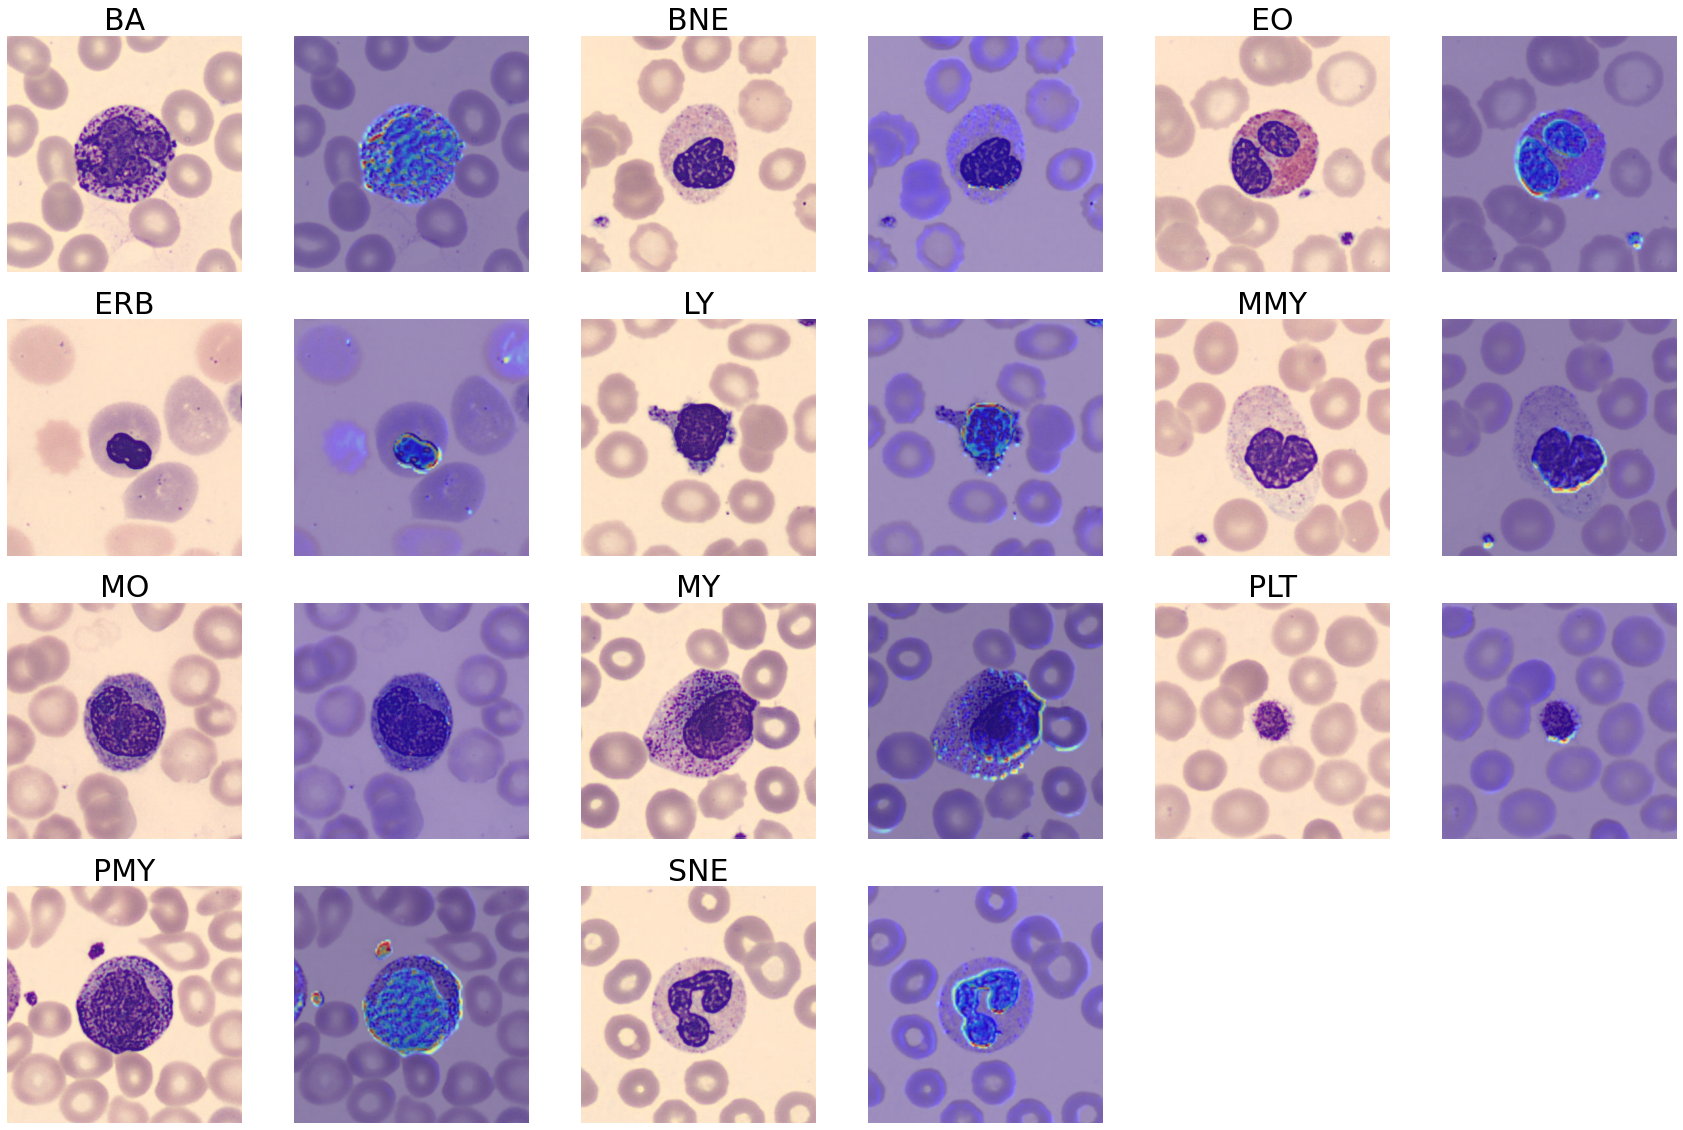

In [ ]:
fig = plt.figure(figsize = (30, 20))
i = 0

for cell_class in range(n_classes):
  df_temp = df_results[(df_results["label"] == cell_class) & (df_results["well_classified"] == True)]
  id = np.random.choice(df_temp.index, size = 1, replace = False)
  img_path = df_temp.loc[id[0],"img_path"]
 
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, 
                                          class_index = None, alpha = 0.8, plot = False)

  fig.add_subplot(4,6,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(list(label_map.keys())[cell_class], fontsize = 30)
  plt.grid(None)
  plt.axis('off')

  fig.add_subplot(4,6,i+2)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  i += 2

Dans la plupart des cas, **on dirait que le modèle recherche le bord de la région la plus sombre de l'image**. Cela le conduit à délimiter, la plupart du temps :
- le noyau des cellules ou les granulations sombres du cytoplasme, ce qui est pertinent ;
- mais aussi à isoler les artefacts qui peuvent apparaître ça et là (voir l'image de PMY).

Il peut aussi lui arriver de prendre en compte le contour des globules rouges, ce qui est embêtant (SNE, MY).

Si seule la forme du noyau est prise en compte, sachant qu'elle peut varier de façon importante d'une image à l'autre, cela peut expliquer le surapprentissage constaté plus haut.

# Modèle à 8 classes

Ici, on teste une **autre distribution des données**. La répartition des images est faite en **8 classes** :
- **PMY, MY, MMY** sont groupés dans la classe "IG" : immature granulocytes
- **BNE, SNE** sont groupés dans la classe "NEU" : neutrophiles

Techniquement, cela aurait du sens de groupe les BNE dans la catégorie IG, dans la mesure où les BNE sont des neutrophiles immatures. **Nous avons cependant opté pour la répartition proposée dans l'article** "Recognition of peripheral blood cell images using convolutional neural networks" (Acevedo et al., 2019).

In [ ]:
n_classes, df_train, df_test, df_valid = choose_classes(df_train, df_test, df_valid, n_classes = 8)
classes = list(df_train["label"].sort_values().unique())

In [ ]:
classes

['BA', 'EO', 'ERB', 'IG', 'LY', 'MO', 'NEU', 'PLT']

Les images utilisées sont les mêmes que pour 11 classes.

In [ ]:
batch_size = 32
img_height  = 256
img_width = 256

train_generator = ImageDataGenerator()
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()


# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12677 validated image filenames belonging to 8 classes.
Found 1730 validated image filenames belonging to 8 classes.
Found 2544 validated image filenames belonging to 8 classes.
Train : {'BA': 0, 'EO': 1, 'ERB': 2, 'IG': 3, 'LY': 4, 'MO': 5, 'NEU': 6, 'PLT': 7}
Valid : {'BA': 0, 'EO': 1, 'ERB': 2, 'IG': 3, 'LY': 4, 'MO': 5, 'NEU': 6, 'PLT': 7}
Test  : {'BA': 0, 'EO': 1, 'ERB': 2, 'IG': 3, 'LY': 4, 'MO': 5, 'NEU': 6, 'PLT': 7}


## Modèle et entraînement

On utilise toujours la même structure pour le modèle (attention, la couche de sortie n'a plus que 8 neurones) :

In [ ]:
model = Sequential(
    [layers.experimental.preprocessing.Rescaling(1./255, 
                                                 input_shape = (img_height, img_width, 3)),
     layers.Conv2D(filters = 30,
                   kernel_size = (5,5),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(filters = 16,
                   kernel_size = (3,3),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Dropout(rate = 0.2),
     layers.Flatten(),
     layers.Dense(units = 128, activation = 'relu'),
     layers.Dense(units = n_classes, activation  = 'softmax')
     ])

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [ ]:
## Training

TON = TerminateOnNaN()
control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]

epochs = 30
training_history = model.fit(x = training_set, 
                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set)

Epoch 1/30
397/397 [==============================] - 42s 104ms/step - loss: 1.3377 - accuracy: 0.5149 - val_loss: 0.9603 - val_accuracy: 0.6324
Epoch 2/30
397/397 [==============================] - 41s 103ms/step - loss: 0.9615 - accuracy: 0.6353 - val_loss: 0.9501 - val_accuracy: 0.6399
Epoch 3/30
397/397 [==============================] - 41s 103ms/step - loss: 0.8602 - accuracy: 0.6812 - val_loss: 0.8070 - val_accuracy: 0.6850
Epoch 4/30
397/397 [==============================] - 41s 103ms/step - loss: 0.7220 - accuracy: 0.7440 - val_loss: 0.7436 - val_accuracy: 0.7353
Epoch 5/30
397/397 [==============================] - 41s 102ms/step - loss: 0.6056 - accuracy: 0.7895 - val_loss: 0.6053 - val_accuracy: 0.8017
Epoch 6/30
397/397 [==============================] - 41s 103ms/step - loss: 0.4952 - accuracy: 0.8272 - val_loss: 0.5484 - val_accuracy: 0.8110
Epoch 7/30
397/397 [==============================] - 41s 103ms/step - loss: 0.4162 - accuracy: 0.8587 - val_loss: 0.5245 - val_ac

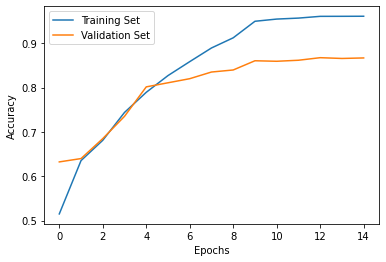

In [ ]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(training_accuracy, label = 'Training Set')
plt.plot(validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

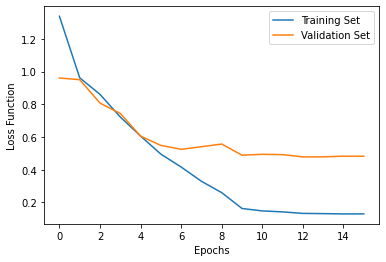

In [ ]:
training_loss = training_history.history['loss']
validation_loss = training_history.history['val_loss']

plt.figure()
plt.plot(training_loss, label = 'Training Set')
plt.plot(validation_loss, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.legend()
plt.show()

Le modèle overfitte à partie de l'epoch 4, mais l'ampleur de l'écart entre entraînement et validation est plus faible que précédemment.

## Évaluation et commentaires

On commence par calculer l'accuracy globale sur le jeu de test :

In [ ]:
model.evaluate(testing_set)

80/80 [==============================] - 7s 87ms/step - loss: 0.4846 - accuracy: 0.8608


[0.4846499562263489, 0.8608490824699402]

Elle est comparable à celle mesurée pour le jeu de validation.

Elle est surtout **nettement meilleure que lorsqu'on cherche à modéliser 11 classes**.

Affichons le rapport de classification et la matrice de confusion :

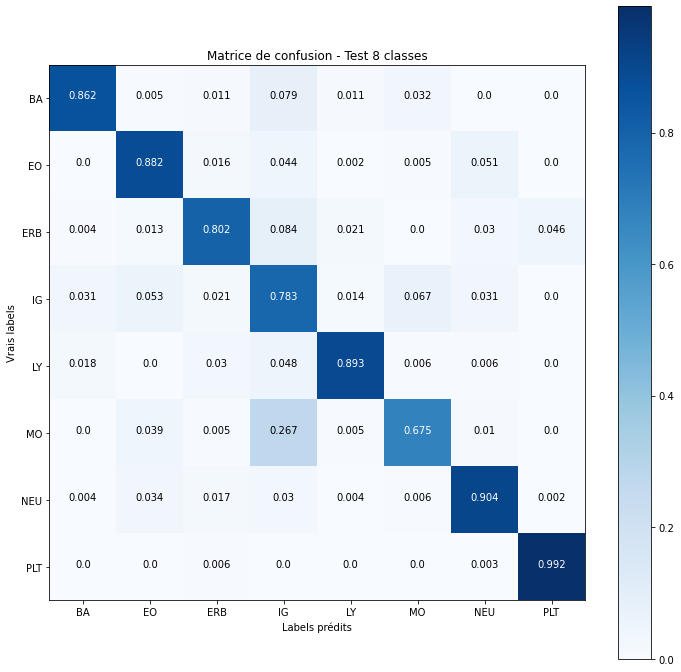

Classification Report - Test 8 classes


precision    recall  f1-score support
BA   0.895604  0.862434  0.878706     189
EO   0.879908  0.881944  0.880925     432
ERB  0.844444  0.801688  0.822511     237
IG   0.711497  0.782816  0.745455     419
LY   0.898204  0.892857  0.895522     168
MO   0.776536  0.674757  0.722078     206
NEU  0.912381  0.903774  0.908057     530
PLT  0.967742  0.991736  0.979592     363

In [ ]:
y_pred, df_report = print_classification_report(testing_set, label_map, title = "Test 8 classes")

Rappelons d'abord que IG = MY, MMY & PMY et que NEU = SNE + BNE.

Le fait de fusionner ces classes a conduit à une très nette amélioration des F1-scores correspondants (**on masque partiellement les difficultés du modèle**).

Cependant, il peut être **pertinent de distinguer les sous-classes les plus immatures**, comme les PMY, car leur présence en grand excès peut traduire l'existence de maladies graves, comme certains types de leucémies.

# Effet de l'augmentation de données

Nous revenons à 11 classes et allons implémenter de l'augmentation de données pour le jeu d'entraînement.

In [ ]:
df_train = leuko.generate_images_df(path/'training_set')
df_test = leuko.generate_images_df(path/'testing_set')
df_valid = leuko.generate_images_df(path/'validation_set')

In [ ]:
n_classes, df_train, df_test, df_valid = choose_classes(df_train, df_test, df_valid, n_classes = 11)

In [ ]:
batch_size = 32
img_height  = 256
img_width = 256

train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True,
                                     vertical_flip = True)
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()


# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12677 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.
Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


## Modèle & Entraînement

In [ ]:
model = Sequential(
    [layers.experimental.preprocessing.Rescaling(1./255, 
                                                 input_shape = (img_height, img_width, 3)),
     layers.Conv2D(filters = 30,
                   kernel_size = (5,5),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(filters = 16,
                   kernel_size = (3,3),
                   activation = 'relu',
                   padding = 'valid'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Dropout(rate = 0.2),
     layers.Flatten(),
     layers.Dense(units = 128, activation = 'relu'),
     layers.Dense(units = n_classes, activation  = 'softmax')
     ])

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [ ]:
## Training

TON = TerminateOnNaN()
control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]

epochs = 30
training_history = model.fit(x = training_set, 
                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set)

Epoch 1/30
397/397 [==============================] - 180s 454ms/step - loss: 1.5238 - accuracy: 0.4656 - val_loss: 1.3354 - val_accuracy: 0.5457
Epoch 2/30
397/397 [==============================] - 180s 452ms/step - loss: 0.8985 - accuracy: 0.6687 - val_loss: 0.7018 - val_accuracy: 0.7145
Epoch 3/30
397/397 [==============================] - 180s 453ms/step - loss: 0.6826 - accuracy: 0.7357 - val_loss: 0.6350 - val_accuracy: 0.7653
Epoch 4/30
397/397 [==============================] - 180s 452ms/step - loss: 0.6098 - accuracy: 0.7610 - val_loss: 0.5869 - val_accuracy: 0.7763
Epoch 5/30
397/397 [==============================] - 180s 453ms/step - loss: 0.5694 - accuracy: 0.7753 - val_loss: 0.5846 - val_accuracy: 0.7676
Epoch 6/30
397/397 [==============================] - 181s 456ms/step - loss: 0.5394 - accuracy: 0.7859 - val_loss: 0.5067 - val_accuracy: 0.8116
Epoch 7/30
397/397 [==============================] - 179s 452ms/step - loss: 0.5170 - accuracy: 0.7937 - val_loss: 0.5240 -

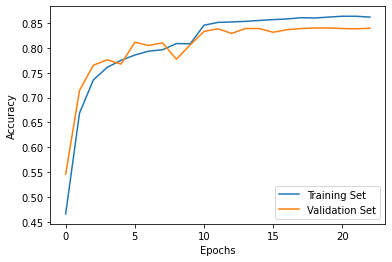

In [ ]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(training_accuracy, label = 'Training Set')
plt.plot(validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

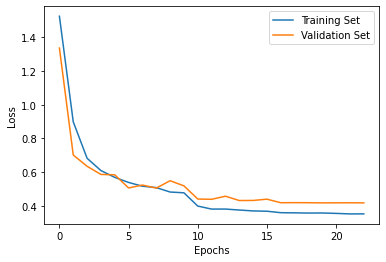

In [ ]:
training_loss = training_history.history['loss']
validation_loss = training_history.history['val_loss']

plt.figure()
plt.plot(training_loss, label = 'Training Set')
plt.plot(validation_loss, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Leukopy/LeNetModel/lenet_save")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/LeNetModel/lenet_save/assets


## Évaluation et analyse

Pour gagner du temps, on importe les poids du modèle déjà entraîné :

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Leukopy/LeNetModel/lenet_save")

In [ ]:
model.evaluate(testing_set)

80/80 [==============================] - 7s 88ms/step - loss: 0.3774 - accuracy: 0.8510


[0.37740373611450195, 0.8510220050811768]

On constate une quasi disparition de l'overfitting, grâce à l'augmentation de données.

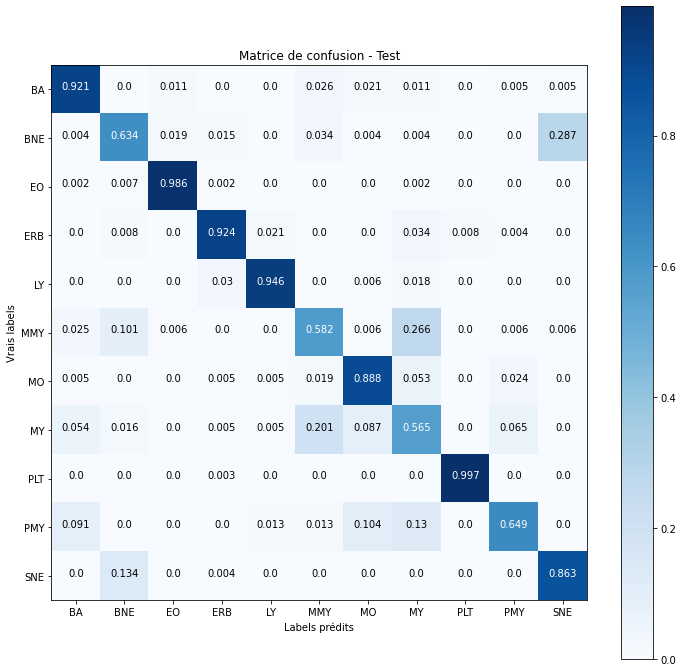

Classification Report - Test


precision    recall  f1-score support
BA   0.878788  0.920635  0.899225     189
BNE  0.742358  0.634328  0.684105     268
EO   0.981567  0.986111  0.983834     432
ERB  0.939914  0.924051  0.931915     237
LY   0.952096  0.946429  0.949254     168
MMY  0.621622  0.582278  0.601307     158
MO    0.85514   0.88835  0.871429     206
MY   0.571429  0.565217  0.568306     184
PLT  0.994505  0.997245  0.995873     363
PMY  0.714286  0.649351  0.680272      77
SNE  0.740984  0.862595  0.797178     262

In [ ]:
y_pred, df_report = print_classification_report(testing_set, label_map, title = "Test")

Autre effet positif, **l'augmentation de données a amélioré le F1-score pour la quasi-totalité des classes**, en particulier celles qui étaient le moins bien décrites.

In [ ]:
df_results = pd.DataFrame(data = {"label":testing_set.classes,
                                  "label_pred":y_pred, 
                                  "img_path":df_test["img_path"]})

df_results["well_classified"] = np.where(df_results["label"] == df_results["label_pred"], True, False)

Intéressons-nous au Grad-CAM des images bien classées :

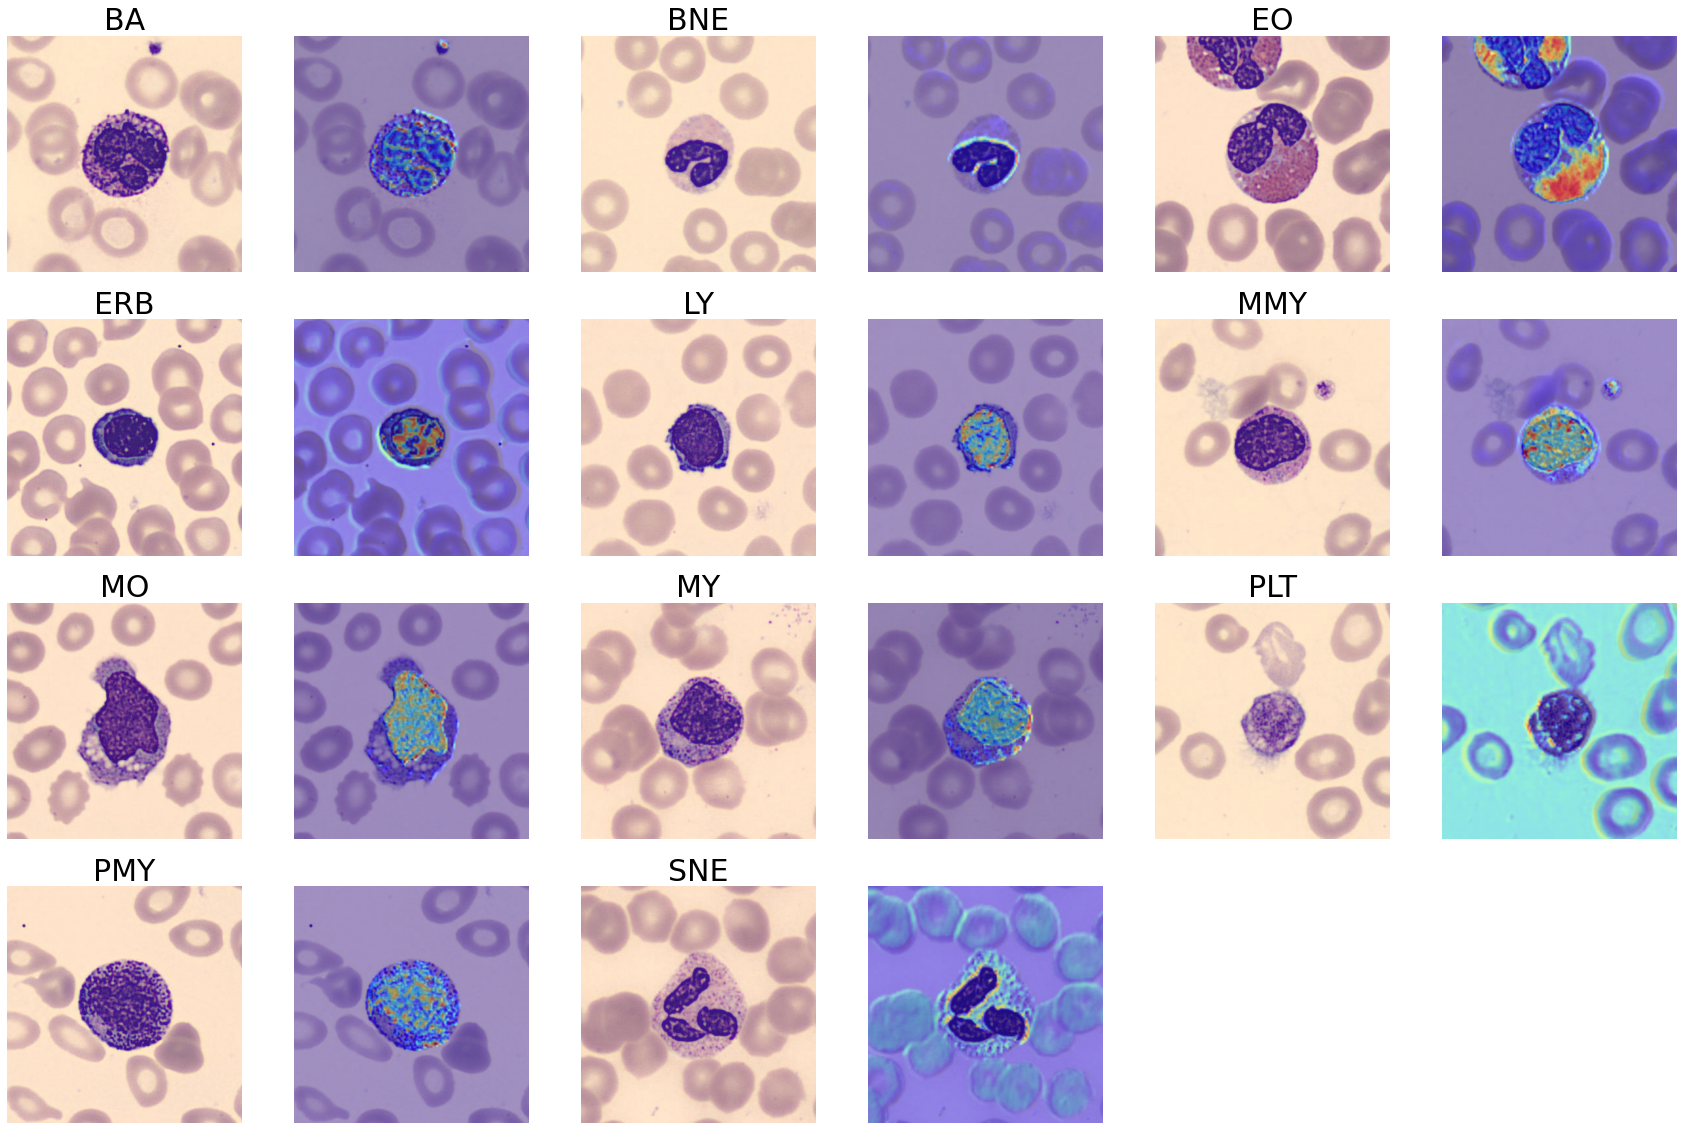

In [ ]:
fig = plt.figure(figsize = (30, 20))
i = 0

for cell_class in range(n_classes):
  df_temp = df_results[(df_results["label"] == cell_class) & (df_results["well_classified"] == True)]
  id = np.random.choice(df_temp.index, size = 1, replace = False)
  img_path = df_temp.loc[id[0],"img_path"]
 
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, 
                                          class_index = None, alpha = 0.8, plot = False)

  fig.add_subplot(4,6,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(list(label_map.keys())[cell_class], fontsize = 30)
  plt.grid(None)
  plt.axis('off')

  fig.add_subplot(4,6,i+2)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  i += 2

L'**augmentation de données a conduit le modèle à prendre en compte d'autres caractéristiques des images** :
- la structure interne du noyau (MO, MY, PMY, MMY)
- les granulations éosinophiles (roses) des EO

L'**augmentation de données semble donc être une piste intéressante** :
- meilleures performances (métriques, moins d'overfitting)
- Grad-CAM plus pertinente